In [1]:
import torch
import torch.nn as nn
import gym

from seagul.nn import Categorical_MLP, MLP, DummyNet, fit_model
from seagul.rl.ppo_switching import ppo_switch
from tqdm import trange
from numpy import pi
import numpy as np

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

policy = MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)
value_fn = MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)
gate_fn = Categorical_MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)

In [8]:
# Generate data for the supervised learning task
env = gym.make('su_cartpole-v0')
num_points = int(2e4)

X = torch.zeros(num_points, env.observation_space.shape[0])  
Y = torch.zeros(num_points,1)

for i in trange(num_points):
        
        point = env.observation_space.sample()
        X[i] = torch.as_tensor(point)
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            Y[i] = 1
        else:
            Y[i] = 0
            

100%|██████████| 20000/20000 [00:01<00:00, 15495.28it/s]


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


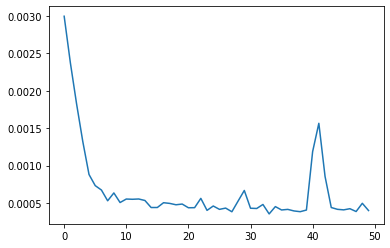

In [9]:
# fit our gating network to the data we generated above

hist = fit_model(gate_fn,X,Y,50)
plt.plot(hist)

In [5]:
# evauluate how well our classifier is doing now

env = gym.make('su_cartpole-v0')
num_points = int(2e4)

pred_Y = torch.zeros(num_points,1)
pred_X = np.zeros((num_points,1))
up_wrong = 0; up_right = 0; down_wrong = 0; down_right = 0;
for i in trange(num_points):
        
        point = env.observation_space.sample()
        y = gate_fn(torch.as_tensor(point,dtype=torch.float64))
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            if y < .5:
                #print("wrong!" , c)
                up_wrong +=1
            else:
                up_right +=1
        else:
            if y > .5:
                #print("wrong again!" , c)
                down_wrong +=1
            else:
                down_right +=1
       
print("balancing controller misclassified: " , up_wrong)
print("balancing controller corectly classified: " , up_right)
print("balancing controller accuracy: " , up_right/(up_right+up_wrong))

     
print("swingup controller misclassified: " , down_wrong)
print("swingup controller corectly classified: " , down_right)
print("balancing controller accuracy: " , down_right/(down_right+down_wrong))

100%|██████████| 20000/20000 [00:04<00:00, 4690.68it/s]

0 1995 663 17342


100%|██████████| 1500/1500 [45:57<00:00,  1.81s/it]


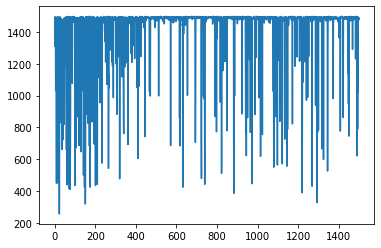

In [10]:
# env2, t_policy, t_val, rewards = ppo('InvertedPendulum-v2', 100, policy, value_fn)
t_policy, t_val, t_gate, rewards, var_dict = ppo_switch(
    "su_cartpole_push-v0", 1500, policy, value_fn, gate_fn, epoch_batch_size=50, reward_stop=1400
)

plt.plot(rewards)

In [5]:
var_dict.keys()

dict_keys(['gate_loss', 'local_gate', 'v_loss', 'local_values', 'p_loss', 'r', 'old_logp', 'logp', 'local_adv', 'local_actions', 'local_states', 'training_generator', 'training_data', 'p_adv_tensor', 'p_action_tensor', 'p_state_tensor', 'adv', 'p_adv_list', 'p_action_list', 'p_state_list', 'ep_adv', 'deltas', 'value_preds', 'ep_gate_tensor', 'ep_path_tensor', 'ep_disc_rewards', 'ep_action_tensor', 'ep_state_tensor', 'done', 'reward', 'state_np', 'logprob', 'action', 'path', '_', 'gate_out', 't', 'gate_list', 'path_list', 'reward_list', 'state_list', 'action_list', 'state', 'gate_tensor', 'path_tensor', 'action_tensor', 'state_tensor', 'disc_rewards_tensor', 'adv_tensor', 'traj_count', 'traj_steps', 'batch_steps', 'episode_reward_sum', 'epoch', 'avg_reward_hist', 'device', 'use_cuda', 'g_optimizer', 'v_optimizer', 'p_optimizer', 'old_gate', 'old_policy', 'obs_size', 'action_size', 'get_path_logp', 'select_path', 'get_action_logp', 'select_action', 'env', 'reward_stop', 'use_gpu', 'v_epo

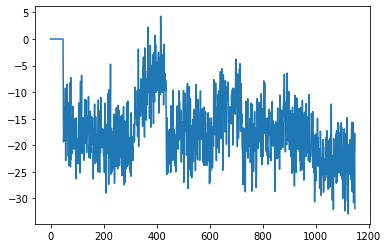

In [7]:
plt.plot(var_dict['action_list'])

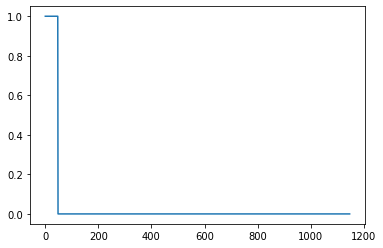

In [8]:
plt.plot(var_dict['path_list'])

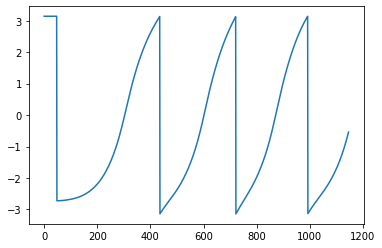

In [9]:
plt.plot(var_dict['state_tensor'][:,0])